In [1]:
import pandas as pd
from pandas import Grouper
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator,DateFormatter, WeekdayLocator
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import numpy as np
import seaborn as sns
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from datetime import timedelta



%matplotlib inline
sns.set_style('darkgrid')
pd.set_option("max.columns", 1000)
pd.set_option("display.max_rows", 1000)
warnings.simplefilter(action="ignore", category=FutureWarning)

## Part 1 ‑ Exploratory data analysis

In [2]:
logins = pd.read_json('logins.json')
logins['login_time'] = pd.to_datetime(logins['login_time'])

In [3]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


### Login Counts 15-min interval

In [5]:
logins_count = logins.groupby([logins['login_time'].dt.floor('15Min')]).size().reset_index(name = 'count')
logins_count.head()

,login_time,count
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1


In [6]:
logins_count['month'] = [d.strftime('%b') for d in logins_count['login_time']]
logins_count['dayOfWeek'] = logins_count['login_time'].dt.day_name()
logins_count['hourOfDay'] = logins_count['login_time'].dt.hour
logins_count = logins_count.assign(sessionOfDay=pd.cut(logins_count['login_time'].dt.hour,[-1, 4, 12, 16, 20, 24],labels=['Mid Night','Morning','Noon','Evening','Night']))
logins_count.head()

,login_time,count,month,dayOfWeek,hourOfDay,sessionOfDay
0,1970-01-01 20:00:00,2,Jan,Thursday,20,Evening
1,1970-01-01 20:15:00,6,Jan,Thursday,20,Evening
2,1970-01-01 20:30:00,9,Jan,Thursday,20,Evening
3,1970-01-01 20:45:00,7,Jan,Thursday,20,Evening
4,1970-01-01 21:00:00,1,Jan,Thursday,21,Night


In [7]:
ymax = logins_count['count'].max()
idx = np.where(logins_count['count'] == ymax)[0][0]
xval = logins_count['login_time'][idx]
xval

Timestamp('1970-03-01 04:30:00')

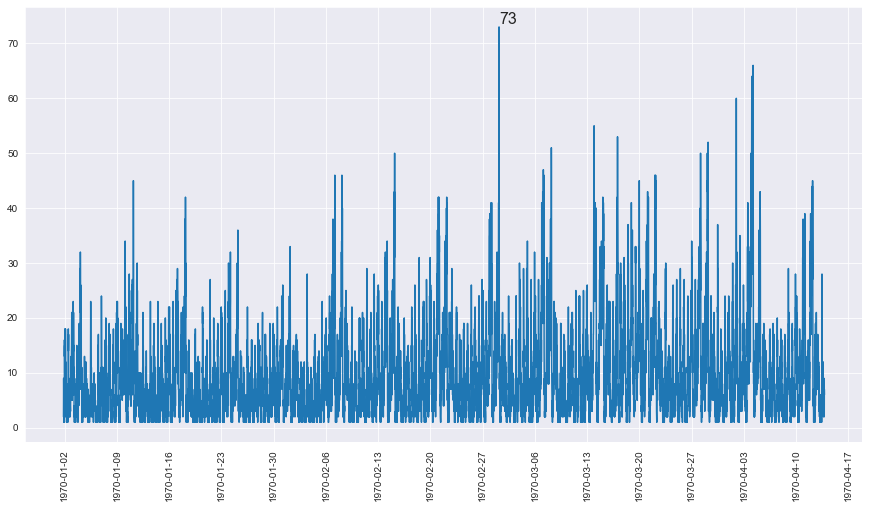

In [8]:
fig, ax = plt.subplots(figsize = (15, 8))
ax.plot(logins_count['login_time'], logins_count['count'])

# Annotate the highest value
ax.text(xval, ymax, ymax, ha='left', va='bottom', fontsize = 16)

ax.xaxis.set_major_locator(DayLocator(interval=7))
ax.xaxis.set_tick_params(rotation=90)

plt.show()

On 1970-03-01 around 04:30:00 there were max active users. Also there is a pattern of peak user logins beginning of every week.

###  dayofWeek vs hourOfDay trend

In [9]:
logins_weekely = logins_count.groupby(['hourOfDay', 'dayOfWeek']).mean().reset_index()
logins_weekely.head()

,hourOfDay,dayOfWeek,count
0,0,Friday,16.250000
1,0,Monday,8.850000
2,0,Saturday,20.900000
3,0,Sunday,18.716667
4,0,Thursday,14.571429


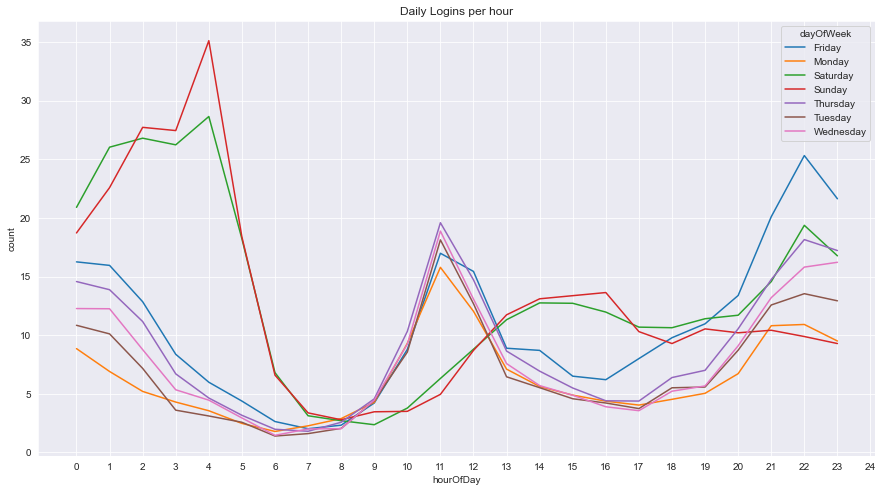

In [10]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = sns.lineplot(x = 'hourOfDay', y = 'count', data = logins_weekely, hue = 'dayOfWeek')
ax.set_title('Daily Logins per hour')
plt.xticks(range(0, 25))
plt.show()

#### dayOfWeek vs sessionOfDay Trend

In [11]:
logins_session = logins_count.groupby(['dayOfWeek', 'sessionOfDay']).mean().reset_index()
logins_session.head()

,dayOfWeek,sessionOfDay,count,hourOfDay
0,Friday,Mid Night,11.899666,1.993311
1,Friday,Morning,7.515982,8.650685
2,Friday,Noon,7.570833,14.500000
3,Friday,Evening,10.535565,18.502092
4,Friday,Night,22.350000,22.000000


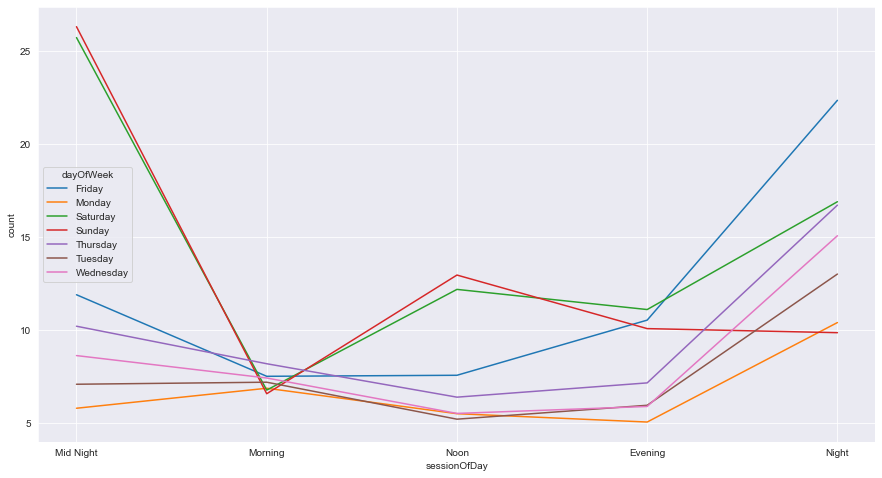

In [12]:
fig, ax = plt.subplots(figsize = (15, 8))
ax = sns.lineplot(x = 'sessionOfDay', y = 'count', data = logins_session, hue = 'dayOfWeek')
#plt.xticks(range(0, 25))
plt.show()

##### Monthly Trend

In [13]:
resampled = logins_count.copy()
resampled.set_index('login_time', inplace = True)
resampled = resampled.resample('12H').mean()
resampled.reset_index(inplace = True)
resampled.head()

,login_time,count,hourOfDay
0,1970-01-01 12:00:00,7.466667,21.533333
1,1970-01-02 00:00:00,6.326087,5.521739
2,1970-01-02 12:00:00,8.297872,17.489362
3,1970-01-03 00:00:00,8.933333,5.244444
4,1970-01-03 12:00:00,8.145833,17.500000


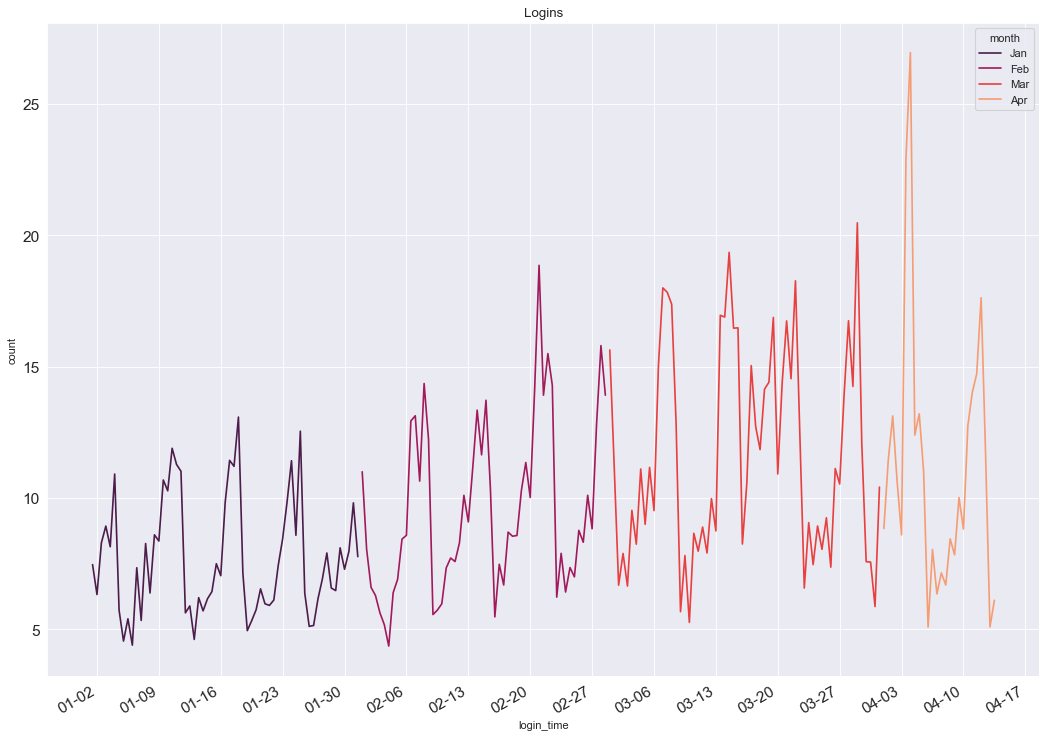

In [14]:
resampled['month'] = [d.strftime('%b') for d in resampled['login_time']]
months= resampled['month'].unique()


# Draw Plot
fig, ax = plt.subplots(figsize=(16,12), dpi= 80)
ax = sns.lineplot('login_time', 'count', data = resampled, hue = 'month', palette = 'rocket')

date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.set_title("Logins")
ax.tick_params(labelsize = 14)
fig.autofmt_xdate()
plt.show()

## Part 2 ‑ Experiment and metrics design

On weekdays Gotham is most active at night and Metropolis is most active during day, however weekends being active for both throughout day. I would suggest Tracking location of the drivers, number of trips and hours of driving in a specific location on weekends, alerts sent to the drivers based on toll policy.

## Part 3 ‑ Predictive modeling

### LOAD DATA

In [15]:
rides = pd.read_json('ultimate_data_challenge.json')
rides.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [16]:
rides['signup_date'] = pd.to_datetime(rides['signup_date'])
rides['last_trip_date'] = pd.to_datetime(rides['last_trip_date'])

In [17]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [18]:
rides.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


### DATA WANGLING

In [19]:
rides[['avg_rating_by_driver', 'avg_rating_of_driver']] = rides[['avg_rating_by_driver', 'avg_rating_of_driver']].fillna(rides[['avg_rating_by_driver', 'avg_rating_of_driver']].mean())

#### Drop Missing Data

In [20]:
rides.isna().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

In [21]:
rides['phone'] = rides['phone'].fillna('Other')
rides['phone'].unique()

array(['iPhone', 'Android', 'Other'], dtype=object)

#### Target Variable Distribution

Number of riders retained and not retained

In [22]:
import datetime
today = datetime.datetime(2014, 7, 1)
rides['active_user'] = rides['last_trip_date'].apply(lambda x: 1 if (today - x).days <=30 else 0)

#rides['active_user'] = rides['trips_in_first_30_days'].apply(lambda x: 1 if x != 0 else 0)

In [23]:
(rides['active_user'] == rides['ultimate_black_user']).sum()

31336

In [24]:
rides['active_user'].value_counts(normalize = True)

0    0.62392
1    0.37608
Name: active_user, dtype: float64

<AxesSubplot:xlabel='active_user', ylabel='count'>

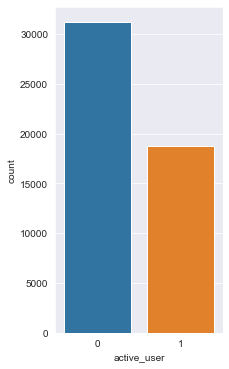

In [25]:
plt.figure(figsize = (3, 6))
sns.countplot(data = rides, x = 'active_user')

37% riders have churned. The dataset does not suffer from data imbalance

In [26]:
rides['active_6months'] = (rides['last_trip_date'] - rides['signup_date']).apply(lambda x: 1 if x > timedelta(days = 30 * 5) else 0)

In [27]:
rides.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,active_6months
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,0


#### Categorical Feature

<AxesSubplot:xlabel='city', ylabel='count'>

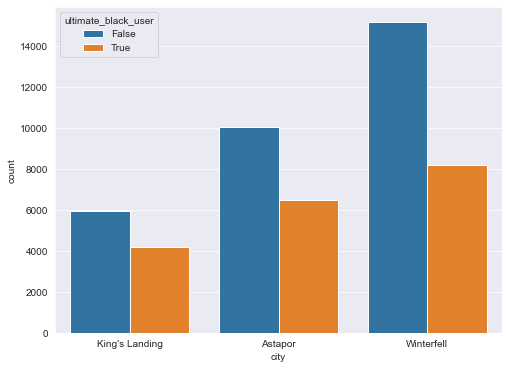

In [28]:
plt.figure(figsize = (8, 6))
sns.countplot(data = rides, x = 'city', hue = 'ultimate_black_user')

Most of the customers are from Winterfall.

<AxesSubplot:xlabel='phone', ylabel='count'>

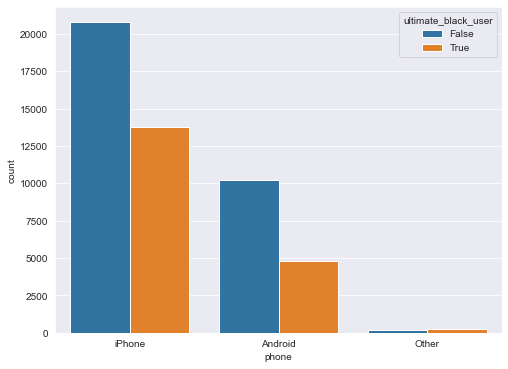

In [29]:
plt.figure(figsize = (8, 6))
sns.countplot(data = rides, x = 'phone', hue = 'ultimate_black_user')

The proportion of riders using iPhone is greater than the proportion of riders using Android phones.

#### Numerical Features

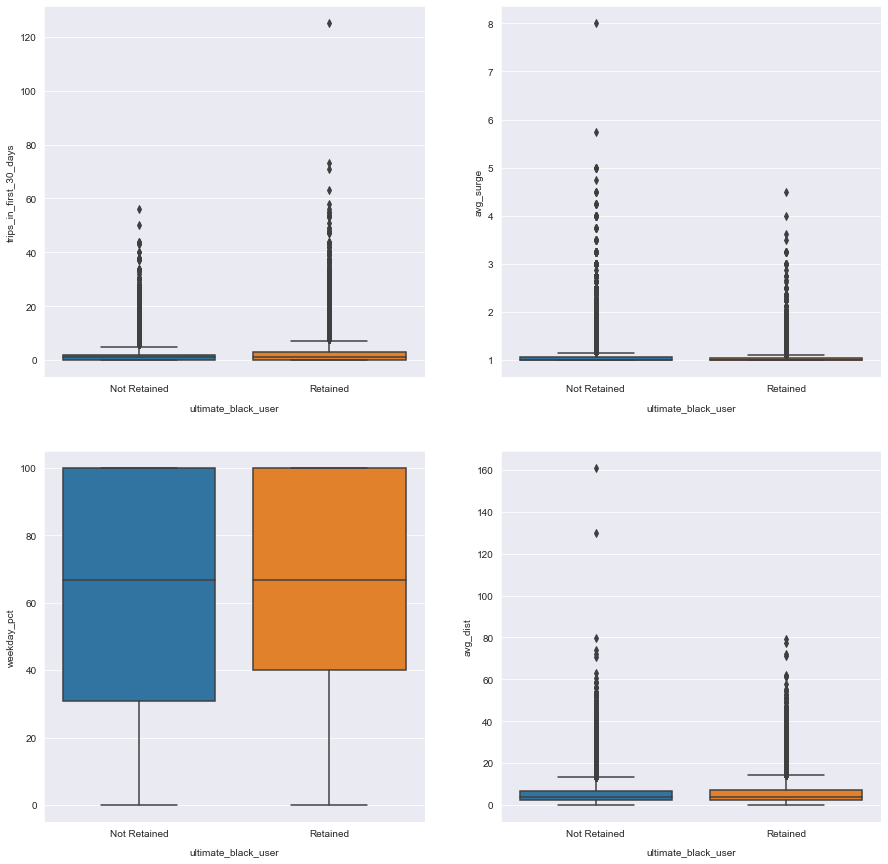

In [30]:
numerical_features = [['trips_in_first_30_days',  'avg_surge'], ['weekday_pct', 'avg_dist']]
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for i in range(2):
    for j in range(2):
        feature = numerical_features[i][j]
        ax1 = sns.boxplot(x='ultimate_black_user', y=feature, data=rides, ax=ax[i][j])
        ax1.set_xlabel('ultimate_black_user', labelpad=10)
        ax1.set_xticklabels(['Not Retained', 'Retained'])

There is no difference in the median for avg_surge, weekday_pct and avg_surge. Ride ratings have no effect no customers

#### Feature Engineering

#### Create Features

In [31]:
rides['total_distance'] = rides['trips_in_first_30_days'] * rides['avg_dist']

In [32]:
rides.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,active_6months,total_distance
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,0,14.68
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,0,0.00
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,0,2.31
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,1,21.24
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,0,43.82


#### Conert type to Category

In [33]:
rides["ultimate_black_user"] = rides["ultimate_black_user"].map({False:0, True:1}).astype("category")
rides["active_user"] = rides["active_user"].astype("category")
rides.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,active_6months,total_distance
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,1,46.2,3.67,5.0,1,0,14.68
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,0,50.0,8.26,5.0,0,0,0.00
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,0,100.0,0.77,5.0,0,0,2.31
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,1,80.0,2.36,4.9,1,1,21.24
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,0,82.4,3.13,4.9,0,0,43.82


### Dummies

In [34]:
dummies = pd.get_dummies(rides[['city', 'phone']])

In [35]:
dummies.head()

,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,0,1,0,0,0,1
1,1,0,0,1,0,0
2,1,0,0,0,0,1
3,0,1,0,0,0,1
4,0,0,1,1,0,0


In [36]:
dummies.columns

Index(['city_Astapor', 'city_King's Landing', 'city_Winterfell',
       'phone_Android', 'phone_Other', 'phone_iPhone'],
      dtype='object')

In [37]:
rides = pd.concat([rides, dummies], axis = 1)
rides = rides.drop(['city', 'phone'], axis = 1)

In [38]:
rides.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,active_user,active_6months,total_distance,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_Other,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,1,46.2,3.67,5.0,1,0,14.68,0,1,0,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,0,50.0,8.26,5.0,0,0,0.00,1,0,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,0,100.0,0.77,5.0,0,0,2.31,1,0,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,1,80.0,2.36,4.9,1,1,21.24,0,1,0,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,0,82.4,3.13,4.9,0,0,43.82,0,0,1,1,0,0


### Train Test Split

In [39]:
X = rides.drop(['active_6months', 'signup_date', 'last_trip_date', 'active_user'], axis = 1)
y = rides['active_6months']

In [40]:
y.value_counts(normalize = True)

0    0.75604
1    0.24396
Name: active_6months, dtype: float64

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, shuffle=True)

### Logistic Regression

In [42]:
param_grid_log = {
    'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100],
    'penalty': ['l2', 'l1']
}

lr = LogisticRegression(max_iter = 1000)
lr_grid = GridSearchCV(lr, param_grid=param_grid_log, cv=3, verbose=1, n_jobs=-1)
lr_grid.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  42 | elapsed:    8.5s finished


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.05, 0.1, 1, 10, 100],
                         'penalty': ['l2', 'l1']},
             verbose=1)

In [43]:
print('Best Parameters', lr_grid.best_params_)
print('Training accuracy score from tuned model:', lr_grid.best_score_*100)

Best Parameters {'C': 0.1, 'penalty': 'l2'}
Training accuracy score from tuned model: 77.14770939999046


In [44]:
lr_grid_best = lr_grid.best_estimator_
y_pred_lr = lr_grid_best.predict(X_test)

In [45]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.78      0.96      0.86     13110
           1       0.60      0.18      0.28      4390

    accuracy                           0.76     17500
   macro avg       0.69      0.57      0.57     17500
weighted avg       0.73      0.76      0.71     17500



<AxesSubplot:>

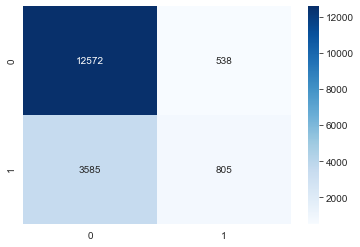

In [46]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot = True, fmt = '', cmap = 'Blues')

### Random forest Classifier

In [47]:
param_grid = {
              'max_depth': [2, 5, 10, 15], 
              'max_features': [2, 4, 6],
              'n_estimators':[10, 20 ,30, 50, 100, 150],
              'min_samples_split': [2, 3, 5]
             }

In [48]:
rf = RandomForestClassifier()
rf_grid = GridSearchCV(rf, param_grid, cv=3, verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)

Fitting 3 folds for each of 216 candidates, totalling 648 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 648 out of 648 | elapsed:  2.8min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 5, 10, 15], 'max_features': [2, 4, 6],
                         'min_samples_split': [2, 3, 5],
                         'n_estimators': [10, 20, 30, 50, 100, 150]},
             verbose=1)

In [49]:
print('Best Parameters', rf_grid.best_params_)
print('Training accuracy score from tuned model:', rf_grid.best_score_*100)

Best Parameters {'max_depth': 10, 'max_features': 6, 'min_samples_split': 5, 'n_estimators': 50}
Training accuracy score from tuned model: 80.03077563063059


In [50]:
rf_grid_best = rf_grid.best_estimator_
y_pred_rf = rf_grid_best.predict(X_test)

In [51]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     13110
           1       0.64      0.39      0.48      4390

    accuracy                           0.79     17500
   macro avg       0.73      0.66      0.67     17500
weighted avg       0.77      0.79      0.77     17500



<AxesSubplot:>

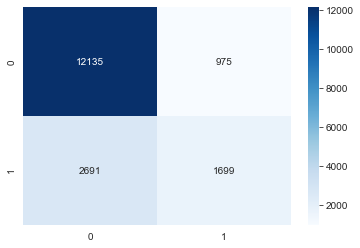

In [52]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot = True, fmt = '', cmap = 'Blues')

Comparison of ROC Curves for the three models

In [53]:
# Calculating AUC score for X_test
fpr_lr_test, tpr_lr_test, thresholds_lr_test = roc_curve(y_test, y_pred_lr)
auc_lr_test = auc(fpr_lr_test, tpr_lr_test) 

# Calculating AUC score for X_test
fpr_rf_test, tpr_rf_test, thresholds_rf_test = roc_curve(y_test, y_pred_rf)
auc_rf_test = auc(fpr_rf_test, tpr_rf_test) 

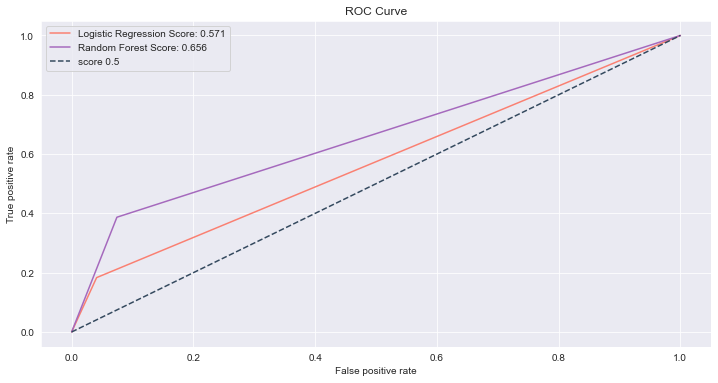

In [54]:
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_lr_test, tpr_lr_test, label = f'Logistic Regression Score: {str(round(auc_lr_test, 3))}', color='#FA8072')
#plt.plot(fpr_svm, tpr_svm, label = f'SVM RBF Score: {str(round(auc_svm, 3))}', color='#82E0AA')
plt.plot(fpr_rf_test, tpr_rf_test, label = f'Random Forest Score: {str(round(auc_rf_test, 3))}', color='#A569BD')
plt.plot([0,1], [0,1], '--', label = 'score 0.5', color='#34495E')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

#### Feature Importances

In [55]:
importances = rf_grid_best.feature_importances_
rf_importances = pd.Series(importances, index=X_train.columns)

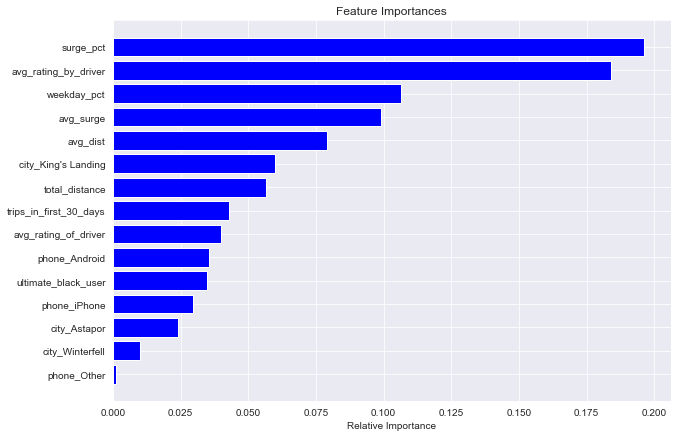

In [56]:
features = X_train.columns
importances = rf_grid_best.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [57]:
feature_importance = zip(features, importances)
feature_importance = sorted(feature_importance, key=lambda x:x[1], reverse=True)

for i, j in feature_importance:
    print(f"Weight: {j:.3f} | Feature: {i}")

Weight: 0.196 | Feature: surge_pct
Weight: 0.184 | Feature: avg_rating_by_driver
Weight: 0.106 | Feature: weekday_pct
Weight: 0.099 | Feature: avg_surge
Weight: 0.079 | Feature: avg_dist
Weight: 0.060 | Feature: city_King's Landing
Weight: 0.057 | Feature: total_distance
Weight: 0.043 | Feature: trips_in_first_30_days
Weight: 0.040 | Feature: avg_rating_of_driver
Weight: 0.036 | Feature: phone_Android
Weight: 0.035 | Feature: ultimate_black_user
Weight: 0.030 | Feature: phone_iPhone
Weight: 0.024 | Feature: city_Astapor
Weight: 0.010 | Feature: city_Winterfell
Weight: 0.001 | Feature: phone_Other
